# Manipulating Green functions

It is now time to start using some of the tools of TRIQS. Most TRIQS tools are also exposed as python modules.
From a practical point of view, this means that you can think of TRIQS as a python library, just like
numpy or matplotlib.

One of the central objects of a many-body calculation is a Green's function. In TRIQS, there are four main kinds of Green's
functions:

- Real-frequency Green functions
- Imaginary-frequency Matsubara Green functions
- Imaginary-time Matsubara Green functions
- Real-time Green functions (will not be covered in this tutorial)

In general, because of symmetries, Green's functions can have a *block structure*.

$$
\hat{G} =
\begin{pmatrix}
\hat{g}^0 & 0 & \cdots & \cdots \\
0 & \hat{g}^1 & 0 & \cdots \\
\cdots & 0 & \hat{g}^2 & 0 \\
\cdots & \cdots & \cdots & \cdots
\end{pmatrix}
$$

Here the $\hat{g}^i$ are Green's functions with non-zero elements $g^i_{ab}$. In principle they can have
different dimensions.

For example, you can imagine a system of 5 $d$-orbitals that are split by a
crystal field into 3 $t_{2g}$-orbitals and 2 $e_g$-orbitals. For symmetry reasons, you can have a
situation where these orbitals do not talk to each other. In that case, the complete Green's function
would have two blocks, one of size 3x3 corresponding to the $t_{2g}$ orbitals and one of size 2x2 corresponding
to the $e_g$ orbitals. 

$$
\hat{G} =
\begin{pmatrix}
\hat{g}^{e_g} & 0  \\
0 & \hat{g}^{t_{2g}}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
g^{e_g}_{00} & g^{e_g}_{01} \\
g^{e_g}_{10} & g^{e_g}_{11}
\end{pmatrix} & 0 \\
0 & \begin{pmatrix}
g^{t_{2g}}_{00} & g^{t_{2g}}_{01} & g^{t_{2g}}_{02} \\
g^{t_{2g}}_{10} & g^{t_{2g}}_{11} & g^{t_{2g}}_{12} \\
g^{t_{2g}}_{20} & g^{t_{2g}}_{21} & g^{t_{2g}}_{22} \\
\end{pmatrix}
\end{pmatrix}
$$

To summarize, an element of a Green's function has three indices: an index for the
block and two indices within the block: $g^a_{ij}$.

Importing the relevant TRIQS library
------------------------------------

The first step to use Green's functions is to import the relevant library of TRIQS.
We also import numpy and configure the size of the plots.

In [1]:
from triqs.gf import *

In [2]:
%matplotlib inline 
import numpy as np

# make plots show up directly in the notebook:
# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['savefig.dpi']=100 

Real-frequency Green's functions
--------------------------------

### Example 1: eg + t2g orbitals

Let's see how to define a real-frequency Green's function. We will take the example of $e_g$ and $t_{2g}$ orbitals. We first have to define the two blocks:

In [3]:
g_eg = GfReFreq(indices=[0,1], window=[-3.0,3.0])
g_t2g = GfReFreq(indices=[0,1,2], window=[-3.0,3.0])

The `indices` keyword lets you choose how many indices are in the Green function. The second keyword `window` sets the frequency $\omega$-range to be considered. Here we use a regular mesh with a default number of points. Now we put these two blocks in the full Green's function $G$:

In [4]:
G = BlockGf(name_list=['eg', 't2g'], block_list=[g_eg, g_t2g])

Let's see how we can put something in the Green's function. We use the operator `<<` to fill the Green's function with the evaluation of the formula on the right hand side at the $\omega$-points of the mesh, i.e. `Omega` is replaced by the values of the mesh.

In [5]:
V1 = 0.1
V2 = 0.2

# The e_g part
G['eg'][0,0] << Omega
G['eg'][0,1] << V1
G['eg'][1,0] << V1
G['eg'][1,1] << Omega 
G['eg'].invert()

# The t_2g part
G['t2g'][0,0] << Omega+2
G['t2g'][1,1] << Omega+2
G['t2g'][2,2] << Omega+2
G['t2g'][0,2] << V2
G['t2g'][2,0] << V2
G['t2g'].invert()

In the example above we have filled the $e_g$ part with

$$
g^{eg} =
\begin{pmatrix}
\omega & V_1 \\
V_1 & \omega
\end{pmatrix}^{-1}
$$

and the $t_{2g}$ part with

$$
g^{t_{2g}} =
\begin{pmatrix}
\omega+2 & 0 & V_2 \\
0 & \omega+2 & 0\\
V_2 & 0 & \omega+2
\end{pmatrix}^{-1}
$$

The full Green's function is now

$$
G =
\begin{pmatrix}
\begin{pmatrix}
\omega & V_1 \\
V_1 & \omega
\end{pmatrix}^{-1} & 0 \\
0 & \begin{pmatrix}
\omega+2 & 0 & V_2 \\
0 & \omega+2 & 0\\
V_2 & 0 & \omega+2
\end{pmatrix}^{-1}
\end{pmatrix}
$$

### Example 2: An impurity in a bath

Now we consider the problem of a single impurity level embedded in a flat conduction bath $\Gamma$ of electrons.
We want to construct the corresponding Green’s function:

$$
g^\mathrm{imp} (\omega) = \frac{1}{\omega - \epsilon_d - \Delta(\omega)}
\qquad \text{with} \qquad \Delta(\omega) = V^2 \Gamma(\omega)
$$

In the equation above $\epsilon_d$ is the energy of the impurity level and $\Gamma$ is the Green's function of
a flat conduction bath. The transition amplitude between the flat conduction bath and the impurity
is given by $V$. Let's see how to define and then plot this Green's function.

In [6]:
eps_d, V = 0.3, 0.2

g = GfReFreq(indices = [0], window = (-2, 2), name = "$G_{imp}$")
g << inverse(Omega - eps_d - V**2 * Flat(1.5))

Greens Function $G_{imp}$ with mesh Linear Mesh of size 10000 and target_rank 2: 

Note the predefined function `Flat(D)` for a flat conduction bath $\Gamma(\omega)$
of half-bandwidth $D$.
Let's plot the impurity Green's function. To do so we first include the matplotlib interface
defined in TRIQS. Note that the function to plot Green's function is `oplot` and not just
`plot` like in matplotlib. By default, both the real and imaginary parts are plotted.

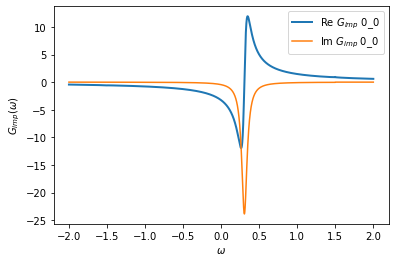

In [7]:
from triqs.plot.mpl_interface import oplot,plt

oplot(g, '-', linewidth=2) 

We can plot the spectral function, which is defined as

$$ A(\omega) = -\frac{1}{\pi} \, \mathrm{Im} \, G $$

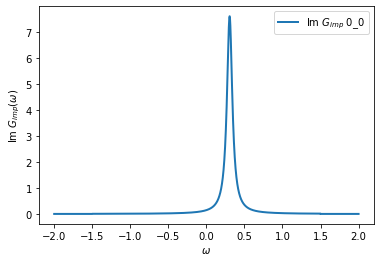

In [8]:
oplot(-g.imag/np.pi, linewidth=2)
#plt.ylim(0,0.001)

As expected the spectral function is peaked at $\epsilon_d$. Note that in this example, the Green's function does not have a block structure. This is why we directly worked with `g` (that is a `GfReFreq`) without defining a block Green's function with `BlockGf`. In general, the same operations can be applied on a `BlockGf` and on a `GfReFreq`. So the example above could also have been written:

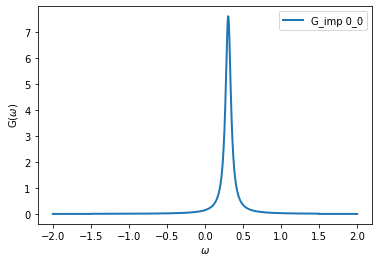

In [9]:
eps_d, V  = 0.3, 0.2

# The small Green's function
g = GfReFreq(indices = [0], window = (-2, 2), name = "imp")

# We define a block Green's function (with just one block!)
G = BlockGf(name_list = ['imp'], block_list = [g])
G << inverse(Omega - eps_d - V**2 * Flat(1.5))
oplot(-G.imag/np.pi, '-', linewidth=2)

### Example 3: Semi-circular density of states

Another predefined Green's function is the one corresponding to a semi-circular spectral function. This will be useful later on. The function is `SemiCircular(D)` with the half-bandwidth $D$ as an argument:

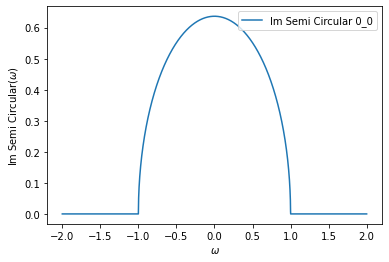

In [10]:
g = GfReFreq(indices = [0], window = (-2, 2), name = "Semi Circular")
g << SemiCircular(1.0)
oplot(-g.imag/np.pi) 

Imaginary-frequency Green's functions
-------------------------------------

These are Green's function defined on the Matsubara axis. The fermionic Matsubara frequencies
are defined by

$$\omega_n = \frac{(2n+1)\pi}{\beta} \qquad n \in \mathbb{Z}$$

where $\beta = 1/T$ is the inverse temperature. These Green's functions are important because
most Monte Carlo algorithms yield results on the Matsubara axis. Let's see how they
are defined, with an example

$$G(i\omega_n) = \frac{1}{i\omega_n - \epsilon}$$

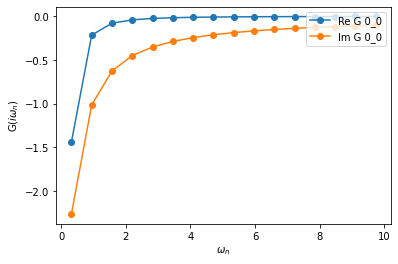

In [11]:
# Define g and fill it
g = GfImFreq(indices=[0], beta=10, name="G") # default: for fermions
g << inverse(iOmega_n - 0.2)

# Plot the Green's function
oplot(g, '-o', x_window=(0,10))

Imaginary-time Green's functions
--------------------------------

Imaginary-time Green's functions are antiperiodic functions defined on the interval $[0, \beta]$. They are
constructed very much like imaginary-frequency Green's functions

In [12]:
g = GfImTime(indices=[0], beta=10)

Standard manipulations
----------------------

Green's functions can be added, multiplied by numbers, etc. The way this is done is quite natural, but it is important to use the << sign and not =.

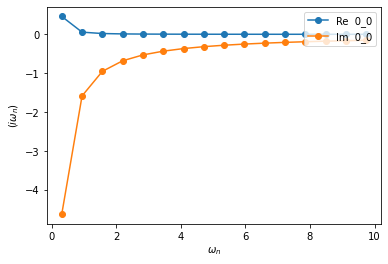

In [13]:
g1 = GfImFreq(indices=[0], beta=10)
g1 << iOmega_n
g1 << 2.0 * (g1 + 0.1)
g1 << inverse(g1)

g2 = g1.copy()
g2 << inverse(iOmega_n)
g2 << g1 + g2

oplot(g2, '-o', x_window=(0,10))

Iterating over the blocks of a `BlockGf`
----------------------------------------

If you have defined a block Green's function, it is often convenient to iterate over all its blocks
with the following construct

In [14]:
g_up = GfImFreq(indices=[0], beta=10)
g_down = GfImFreq(indices=[0], beta=10)
G = BlockGf(name_list=['up', 'down'], block_list=[g_up, g_down])

# Loop over the blocks
for name, g in G:
    print("This is the block called ", name)
    print("The associated Green's function is ", g)

This is the block called  up
The associated Green's function is  G_up
This is the block called  down
The associated Green's function is  G_down


Obtaining the density
---------------------

You can obtain the density with the `density` method

In [15]:
g = GfImFreq(indices=[0], beta=10)
g << inverse(iOmega_n - 0.2)
print("Density = ", g.density()[0,0])

Density =  (0.11920292209838018-4.331174247824966e-15j)


Do not worry about the imaginary component as the machine precision is on the order of $10^{-15}$.

Fourier transforms
------------------

TRIQS allows you to easily Fourier transform Green's functions from imaginary-time to imaginary-frequency.

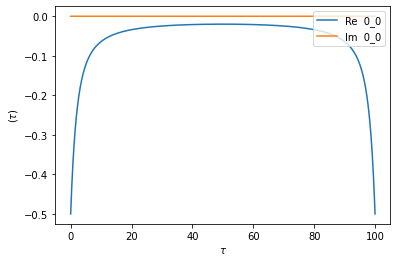

In [16]:
# A Green's function in frequency set to semi-circular
g_w = GfImFreq(indices=[0], beta=100)
g_w << SemiCircular(1.0)

# A Green's function in time set by inverse Fourier transform
g_t = GfImTime(indices=[0], beta=100)
g_t << Fourier(g_w)
oplot(g_t)

(0.0, 5.0)

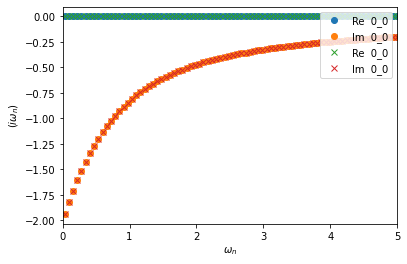

In [17]:
# We can also go the other way
# Let's check that it gives the original result
g_w2 = GfImFreq(indices=[0], beta=100)
g_w2 << Fourier(g_t)
oplot(g_w, 'o', x_window=(0,5))
oplot(g_w2, 'x', x_window=(0,5))
plt.xlim(0,5)

Pade analytical continuation
----------------------------

The Fourier transforms allow to go from time to frequency. A much more delicate thing is to do the so-called "analytical continuation". This means to start from a Matsubara-frequency Green's function and obtain the real-frequency corresponding Green's function. This can formally be done, but turns out to be a mathematically ill-defined problem. As soon as there is a little bit of noise in the Matsubara-frequency data, the continuation to the real axis becomes very unstable.

One of the ways to do this analytical continuation is to use Padé approximants. TRIQS can do that for you in the following way:

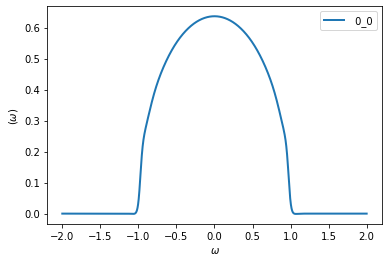

In [18]:
# We define a Matsubara Green's function
g = GfImFreq(indices=[0], beta=50)
g << SemiCircular(1.0)

# Now a real-frequency one
g_real = GfReFreq(indices=[0], window=(-2,2))

# Here we use Pade approximants to set g_real from g
g_real.set_from_pade(g)

oplot(-g_real.imag/np.pi, linewidth=2)

Because the data has no noise, you can see that the Pade continuation did a pretty good job. We will see later, that any noise will completely change this picture!

Exercises
---------

### Exercise 1

Define the following real-frequency Green's function, where $\Gamma$ is the Green's function of a
flat bath (width = 1), $\epsilon_d = 0.3$ and $V=0.2$:

$$
g^\mathrm{s+d} (\omega) =
\begin{pmatrix} \omega - \epsilon_d & V \\\\ V & \Gamma^{-1}
\end{pmatrix}^{-1}
$$

Plot the spectral function for both diagonal components of this Green's function. What
do they represent physically?

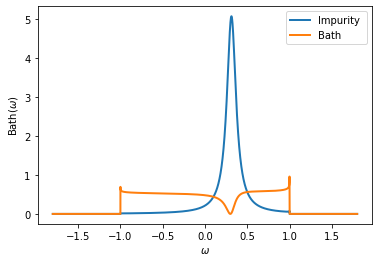

In [19]:
eps_d, V  = 0.3, 0.2
g = GfReFreq(indices = ['s','d'], window = (-2, 2), name = "s+d")
g['d','d'] << Omega - eps_d
g['d','s'] << V
g['s','d'] << V
g['s','s'] << inverse( Flat(1.0) )
g.invert()
oplot( -g['d','d'].imag/np.pi, '-', lw=2, x_window  = (-1.8,1.8), name = "Impurity" )
oplot( -g['s','s'].imag/np.pi, '-', lw=2, x_window  = (-1.8,1.8), name = "Bath" )

### Exercise 2

Plot the density $n(\epsilon)$ as a function of $\epsilon$ for a Green's function $g = 1/(i\omega_n - \epsilon)$. What is the curve that you obtained? How does it change with temperature?

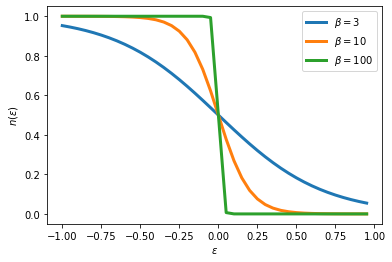

In [20]:
for beta in [3, 10, 100]:
    g = GfImFreq(indices=[0], beta=beta)
    eps_r = np.arange(-1,1,0.05)
    n_r = []
    for eps in eps_r:
        g << inverse(iOmega_n - eps)
        n_r.append(g.density()[0,0].real)
    plt.plot(eps_r, n_r, lw=3, label=r"$\beta = %i$"%beta)
plt.xlabel('$\epsilon$')
plt.ylabel('$n(\epsilon)$')
plt.legend()

### Exercise 3

Define a block Green's function with an *up* and a *down* block. Each block is just a simple 1x1 imaginary-frequency Green's function. Iterate over the blocks to initialize the two blocks to $1/i \omega_n$. What happens if you change $\beta$?


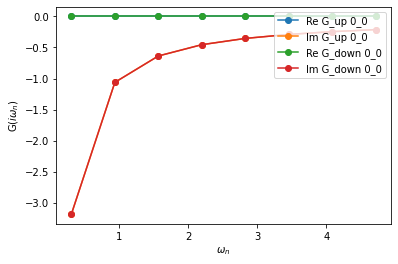

In [21]:
g_up = GfImFreq(indices=[0], beta=10)
g_down = GfImFreq(indices=[0], beta=10)
G = BlockGf(name_list=['up', 'down'], block_list=[g_up, g_down])

# Loop over the blocks
for name, g in G:
    g << inverse(iOmega_n)

oplot(G, '-o', x_window=(0,5))

### Exercise 4

Consider a Hubbard atom with $U=2$ at temperature $T = 1/\beta = 1/10$. The non-interacting and interacting Green's functions for this problem are:

$$
G_0 = \frac{1}{i \omega_n + U/2} \qquad G = \frac{1}{2(i\omega_n + U/2)} + \frac{1}{2(i\omega_n - U/2)}
$$

Using Dyson's equation, verify that the corresponding self-energy is indeed

$$
\Sigma = \frac{U}{2} + \frac{U^2}{4 i\omega_n}
$$

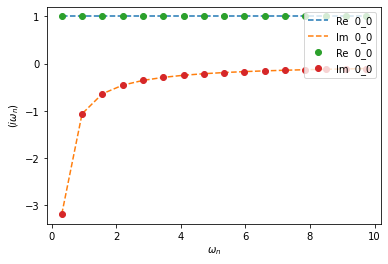

In [22]:
U = 2.0

g_0 = GfImFreq(indices=[0], beta=10)
g = GfImFreq(indices=[0], beta=10)
sigma = GfImFreq(indices=[0], beta=10)
sigma_check = GfImFreq(indices=[0], beta=10)

# Green's functions of the Hubbard atom
g_0 << inverse(iOmega_n + U/2)
g << 0.5*inverse(iOmega_n + U/2) + 0.5*inverse(iOmega_n - U/2)

# Dyson's equation to find the self-energy
sigma << inverse(g_0) - inverse(g)

# Known solution
sigma_check << U/2 + U*inverse(2*iOmega_n)

oplot(sigma, '--', x_window=(0,10))
oplot(sigma_check, 'o', x_window=(0,10))

### Exercise 5

Compute the following second-order self-energy with $U=2$

$$ \Sigma(i\omega_n) = U^2 \int_0^\beta d\tau e^{i \omega_n \tau} G_0(\tau)^3 $$

using an non-interacting $G_0$ given by a semi-circular of half-bandwidth 1. Use Dyson's equation to compute $G(i\omega_n)$.

Hint: The `SemiCircular` initializer only works for frequency Green's functions.

Hint: The "power operator" is not defined for Green's functions. Use multiplication.


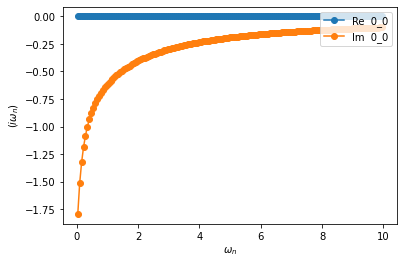

In [23]:
# Set U
U = 2.0
beta = 100

# Define and initialize G0 in freq
g0_w = GfImFreq(indices=[0], beta=beta)
g0_w << SemiCircular(1.0)

# We will need these
g0_t = GfImTime(indices=[0], beta=beta)
sigma_t = GfImTime(indices=[0], beta=beta)
sigma_w = GfImFreq(indices=[0], beta=beta)
g_w = GfImFreq(indices=[0], beta=beta)

# Compute second-order self-energy
g0_t << Fourier(g0_w)
sigma_t << U**2 * g0_t * g0_t * g0_t
sigma_w << Fourier(sigma_t)

# Dyson's equation
g_w << inverse(inverse(g0_w) - sigma_w)

oplot(g_w, '-o', x_window=(0,10))

### Exercise 6

Use Pade approximants to obtain a real-frequency version of the Green's function computed in the
Exercise 5. What is the effect of interactions at second-order perturbation theory? How is it changing with different values of $U$?


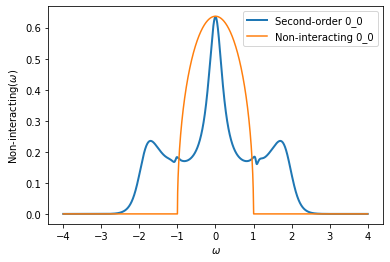

In [24]:
g_r = GfReFreq(indices=[0], window=[-4,4])
g_r.set_from_pade(g_w)
oplot(-g_r.imag/np.pi, lw=2, name="Second-order")

g0_r = GfReFreq(indices=[0], window=[-4,4])
g0_r << SemiCircular(1.0)
oplot(-g0_r.imag/np.pi, name="Non-interacting")